In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

## Data Loading

In [2]:
# Set plot styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

# Load from url to df
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df = pd.read_csv(url)

print("Dataset loaded successfully.")
print(f"Dataset shape: {df.shape}")
print("\nSample of the dataset:")
print(df.head())

Dataset loaded successfully.
Dataset shape: (7214, 53)

Sample of the dataset:
   id                name   first         last compas_screening_date   sex  \
0   1    miguel hernandez  miguel    hernandez            2013-08-14  Male   
1   3         kevon dixon   kevon        dixon            2013-01-27  Male   
2   4            ed philo      ed        philo            2013-04-14  Male   
3   5         marcu brown   marcu        brown            2013-01-13  Male   
4   6  bouthy pierrelouis  bouthy  pierrelouis            2013-03-26  Male   

          dob  age          age_cat              race  ...  v_decile_score  \
0  1947-04-18   69  Greater than 45             Other  ...               1   
1  1982-01-22   34          25 - 45  African-American  ...               1   
2  1991-05-14   24     Less than 25  African-American  ...               3   
3  1993-01-21   23     Less than 25  African-American  ...               6   
4  1973-01-22   43          25 - 45             Other  ...    

## Data Preprocessing

In [3]:
# Filter the dataset according to ProPublica's analysis
df = df[(df['days_b_screening_arrest'] <= 30) & 
        (df['days_b_screening_arrest'] >= -30) &
        (df['is_recid'] != -1) &
        (df['c_charge_degree'] != 'O') &
        (df['score_text'] != 'N/A')]

# Create binary variables for sex
df['sex_binary'] = df['sex'].map({'Female': 0, 'Male': 1})

# Create age groups
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 45, 100], 
                         labels=['<25', '25-35', '35-45', '>45'])

# Target variable is recidivism within two years
print("\nTarget variable distribution:")
print(df['two_year_recid'].value_counts())
print(f"Percentage of recidivism: {df['two_year_recid'].mean()*100:.2f}%")

# Calculate Baseline Recidivism Rates by Protected Groups
# Gender
recidivism_by_sex = df.groupby('sex')['two_year_recid'].mean() * 100
print("\nRecidivism Rate by Gender:")
print(recidivism_by_sex)

# Age
recidivism_by_age = df.groupby('age_group')['two_year_recid'].mean() * 100
print("\nRecidivism Rate by Age Group:")
print(recidivism_by_age)


Target variable distribution:
two_year_recid
0    3363
1    2809
Name: count, dtype: int64
Percentage of recidivism: 45.51%

Recidivism Rate by Gender:
sex
Female    35.148936
Male      47.948769
Name: two_year_recid, dtype: float64

Recidivism Rate by Age Group:
age_group
<25      55.147059
25-35    49.887235
35-45    37.611408
>45      31.723564
Name: two_year_recid, dtype: float64


C:\Users\suuser\AppData\Local\Temp\ipykernel_10712\3140740017.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  recidivism_by_age = df.groupby('age_group')['two_year_recid'].mean() * 100


## Feature Selection and Model Training

In [4]:
features = ['age', 'sex_binary', 'priors_count', 'c_charge_degree']

# Create dummy variables for categorical features
df_model = pd.get_dummies(df[features], columns=['c_charge_degree'], drop_first=True)

# Prepare features and target
X = df_model
y = df['two_year_recid']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Overall model performance
print("\nOverall Model Performance:")
print(classification_report(y_test, y_pred))


Overall Model Performance:
              precision    recall  f1-score   support

           0       0.69      0.76      0.72      1020
           1       0.66      0.57      0.61       832

    accuracy                           0.68      1852
   macro avg       0.67      0.67      0.67      1852
weighted avg       0.67      0.68      0.67      1852



## Fairness Metrics Calculation

In [5]:
# Extract protected attributes for test set
sex_test = df.loc[X_test.index, 'sex'].values
age_group_test = df.loc[X_test.index, 'age_group'].values

# Function to calculate fairness metrics
def calculate_fairness_metrics(y_true, y_pred, protected_attribute):
    # Get unique groups
    groups = np.unique(protected_attribute)
    
    # Dictionary to store metrics
    metrics = {}
    
    for group in groups:
        # Create mask for current group
        mask = (protected_attribute == group)
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true[mask], y_pred[mask]).ravel()
        
        # Statistical Parity (Selection Rate) - percentage predicted as positive
        selection_rate = (tp + fp) / (tp + fp + tn + fn)
        
        # True Positive Rate (TPR) - percentage of actual positives correctly predicted
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # False Positive Rate (FPR) - percentage of actual negatives incorrectly predicted as positive
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        # Positive Predictive Value (PPV) - percentage of predicted positives that are correct
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        metrics[group] = {
            'selection_rate': selection_rate,
            'true_positive_rate': tpr,
            'false_positive_rate': fpr,
            'positive_predictive_value': ppv,
            'count': len(y_true[mask])
        }
    
    return metrics


# Gender metrics
gender_metrics = calculate_fairness_metrics(y_test, y_pred, sex_test)

print("\nFairness Metrics by Gender:")
for gender, metrics in gender_metrics.items():
    print(f"\n{gender} (n={metrics['count']})")
    print(f"Selection Rate (Statistical Parity): {metrics['selection_rate']:.4f}")
    print(f"True Positive Rate: {metrics['true_positive_rate']:.4f}")
    print(f"False Positive Rate: {metrics['false_positive_rate']:.4f}")
    print(f"Positive Predictive Value: {metrics['positive_predictive_value']:.4f}")

#  Gender disparities
gender_disparities = {}
for metric in ['selection_rate', 'true_positive_rate', 'false_positive_rate', 'positive_predictive_value']:
    values = [metrics[metric] for gender, metrics in gender_metrics.items()]
    gender_disparities[metric] = max(values) - min(values)

print("\nGender Disparities:")
for metric, disparity in gender_disparities.items():
    print(f"{metric}: {disparity:.4f}")

# Age metrics
age_metrics = calculate_fairness_metrics(y_test, y_pred, age_group_test)

print("\nFairness Metrics by Age Group:")
for age, metrics in age_metrics.items():
    print(f"\n{age} (n={metrics['count']})")
    print(f"Selection Rate (Statistical Parity): {metrics['selection_rate']:.4f}")
    print(f"True Positive Rate: {metrics['true_positive_rate']:.4f}")
    print(f"False Positive Rate: {metrics['false_positive_rate']:.4f}")
    print(f"Positive Predictive Value: {metrics['positive_predictive_value']:.4f}")

# A disparities
age_disparities = {}
for metric in ['selection_rate', 'true_positive_rate', 'false_positive_rate', 'positive_predictive_value']:
    values = [metrics[metric] for age, metrics in age_metrics.items()]
    age_disparities[metric] = max(values) - min(values)

print("\nAge Group Disparities:")
for metric, disparity in age_disparities.items():
    print(f"{metric}: {disparity:.4f}")



Fairness Metrics by Gender:

Female (n=353)
Selection Rate (Statistical Parity): 0.0935
True Positive Rate: 0.1985
False Positive Rate: 0.0315
Positive Predictive Value: 0.7879

Male (n=1499)
Selection Rate (Statistical Parity): 0.4603
True Positive Rate: 0.6434
False Positive Rate: 0.2995
Positive Predictive Value: 0.6536

Gender Disparities:
selection_rate: 0.3668
true_positive_rate: 0.4449
false_positive_rate: 0.2680
positive_predictive_value: 0.1343

Fairness Metrics by Age Group:

25-35 (n=678)
Selection Rate (Statistical Parity): 0.4218
True Positive Rate: 0.5948
False Positive Rate: 0.2394
Positive Predictive Value: 0.7238

35-45 (n=327)
Selection Rate (Statistical Parity): 0.2966
True Positive Rate: 0.4696
False Positive Rate: 0.2028
Positive Predictive Value: 0.5567

<25 (n=500)
Selection Rate (Statistical Parity): 0.5740
True Positive Rate: 0.6940
False Positive Rate: 0.4353
Positive Predictive Value: 0.6481

>45 (n=347)
Selection Rate (Statistical Parity): 0.1527
True Posit

## Visualization

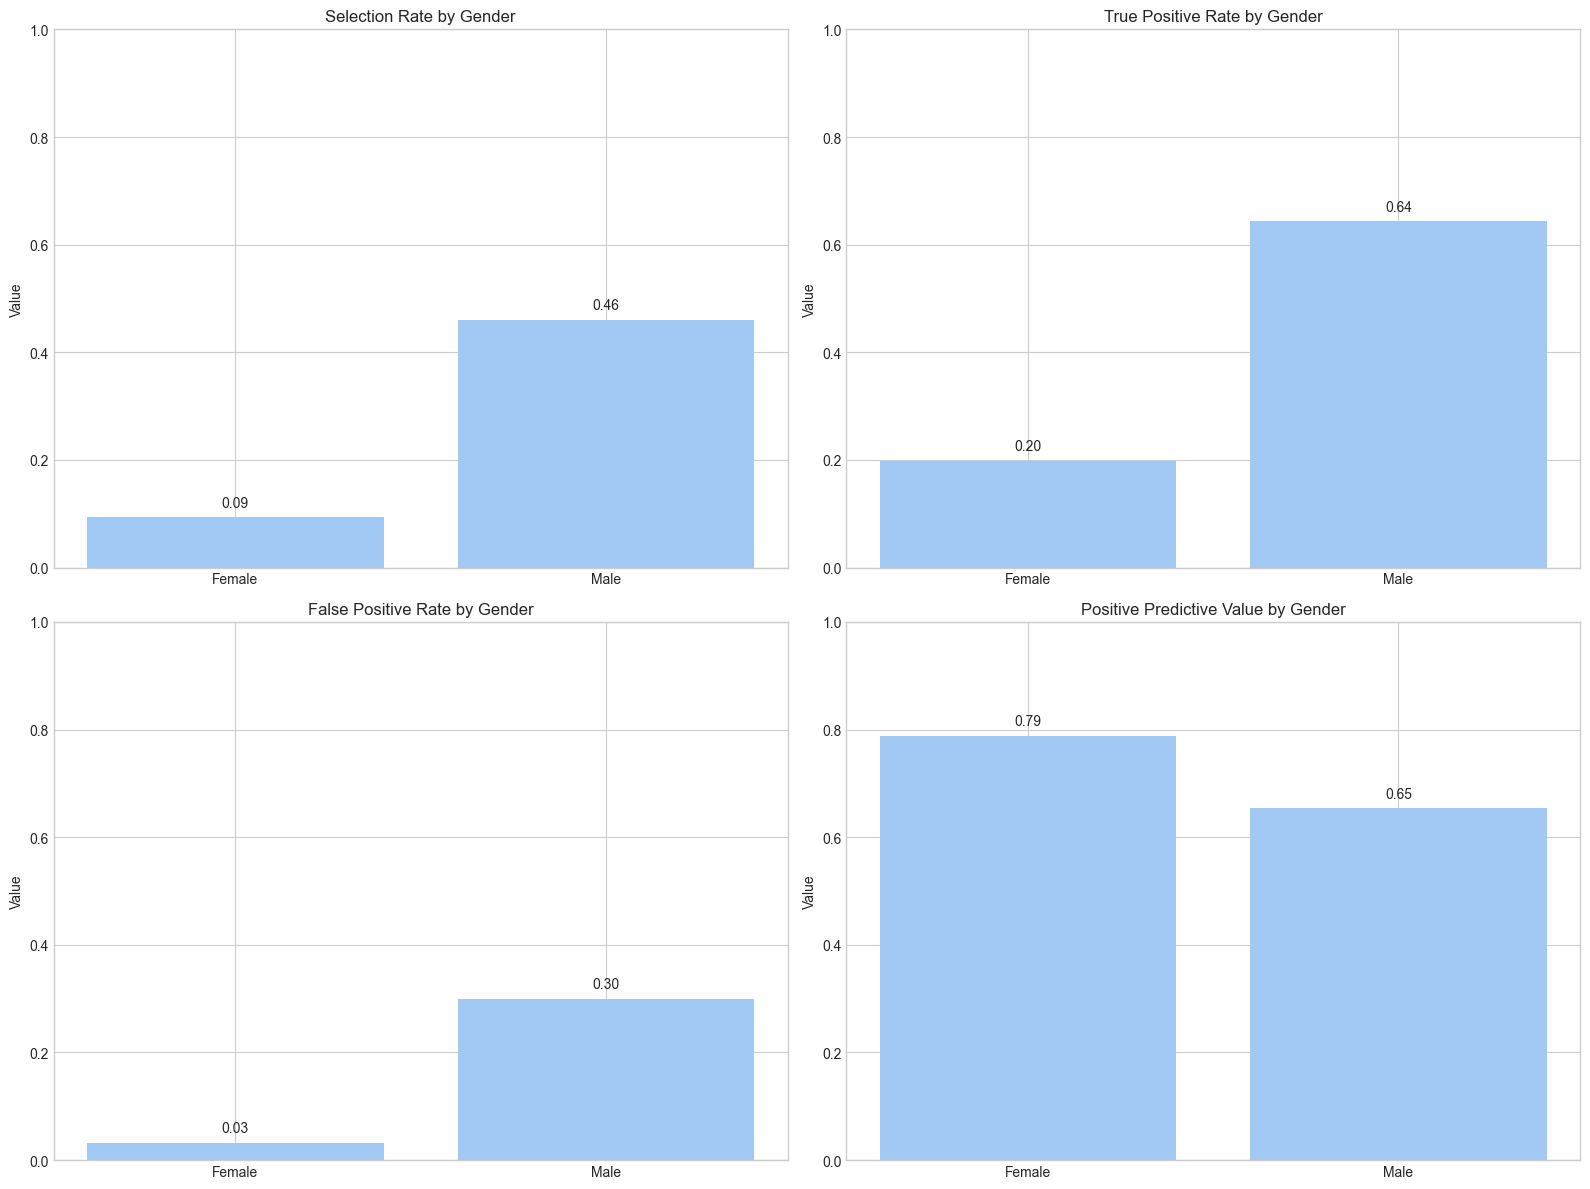

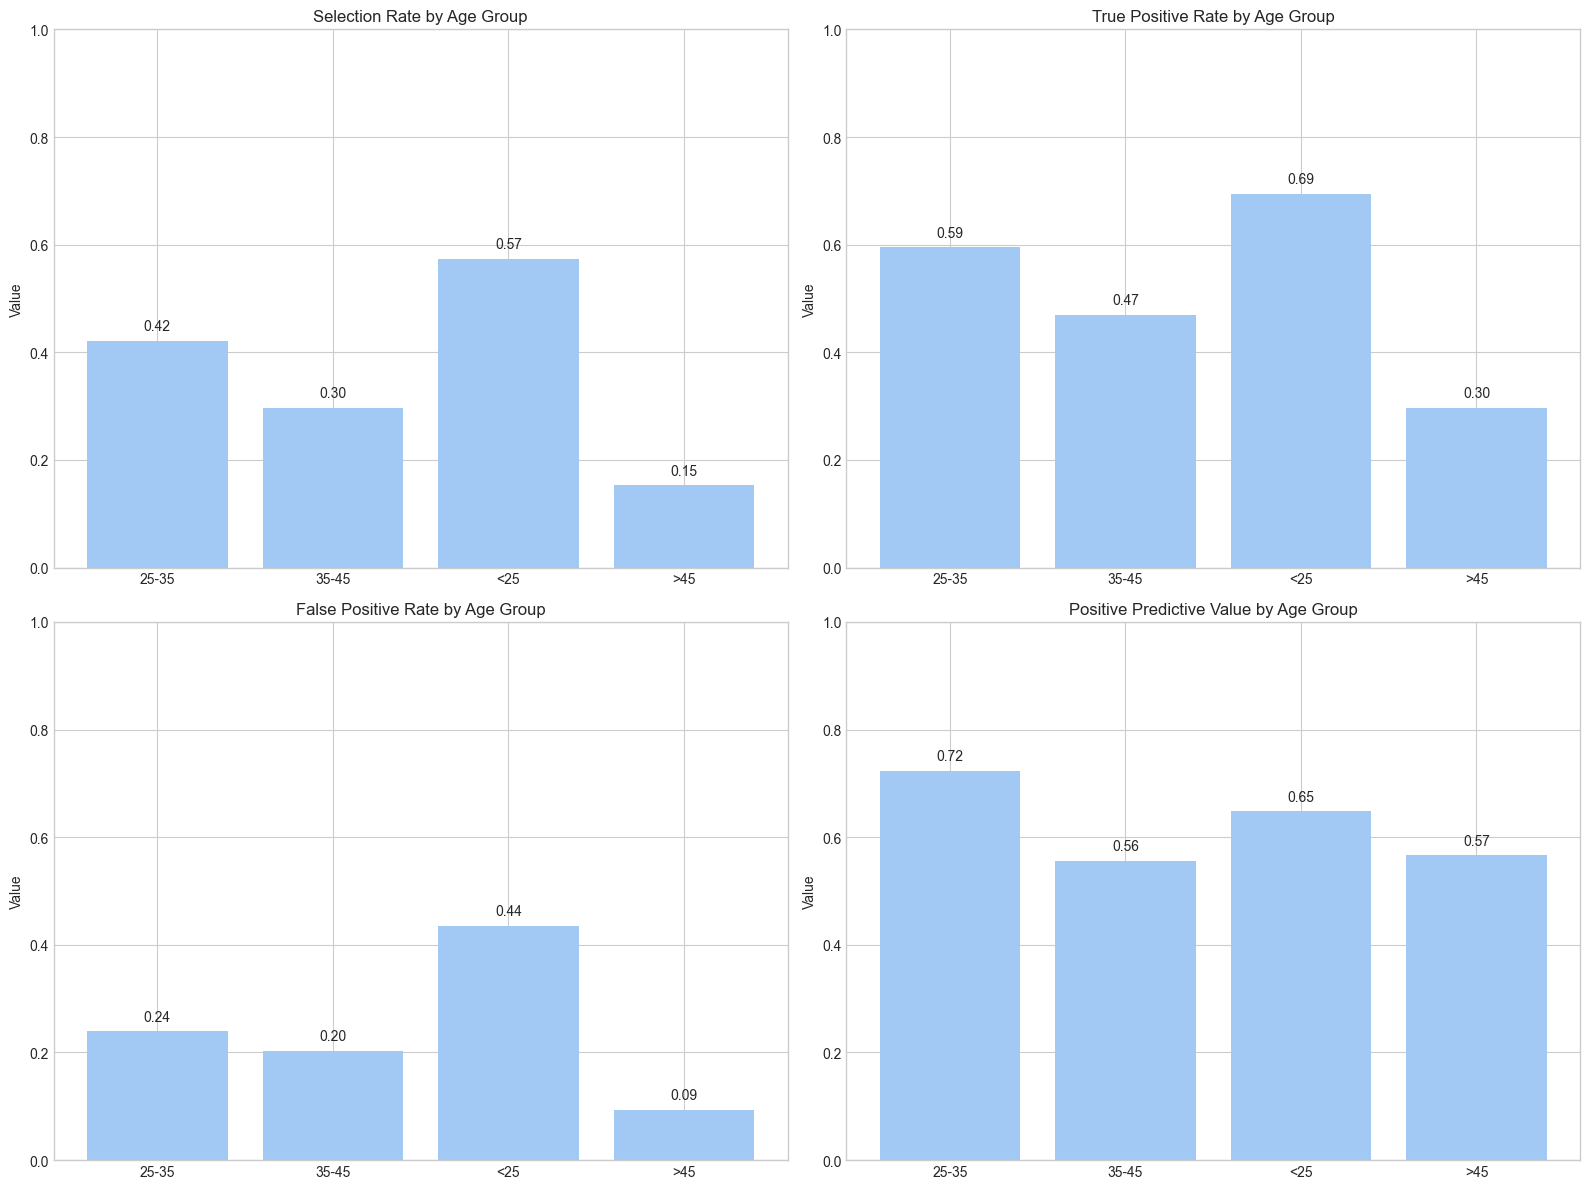

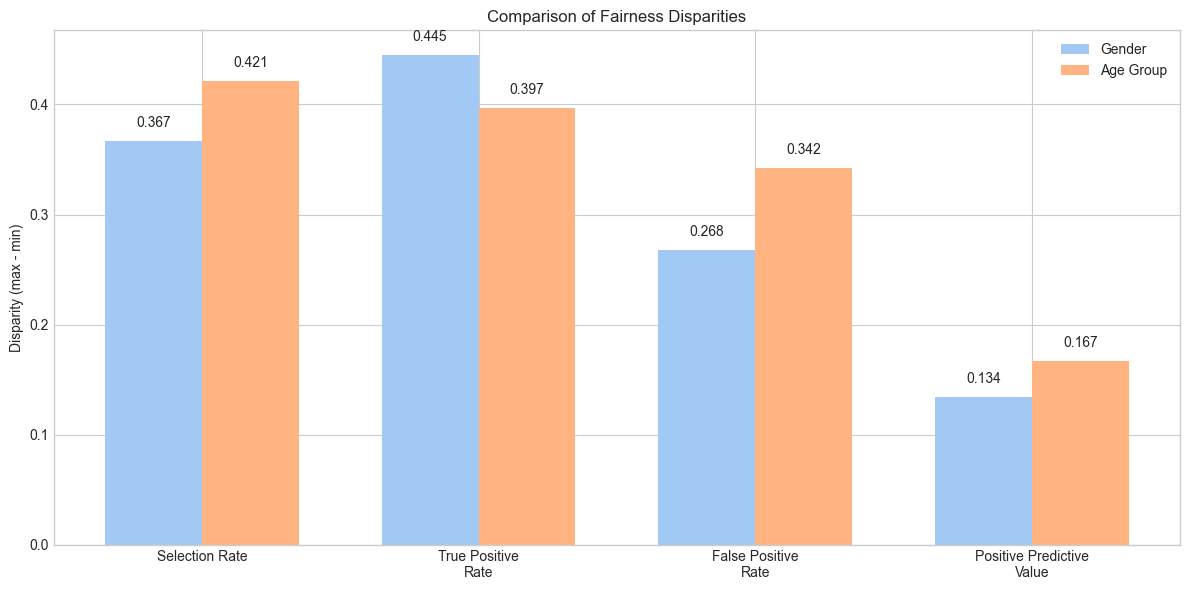

In [6]:
# Create bar charts for metrics by gender
metrics_to_plot = ['selection_rate', 'true_positive_rate', 'false_positive_rate', 'positive_predictive_value']
metric_names = ['Selection Rate', 'True Positive Rate', 'False Positive Rate', 'Positive Predictive Value']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    # Prepare data for plotting
    genders = list(gender_metrics.keys())
    values = [gender_metrics[g][metric] for g in genders]
    
    # Create bar chart
    ax = axes[i]
    ax.bar(genders, values)
    ax.set_title(f'{metric_names[i]} by Gender')
    ax.set_ylabel('Value')
    ax.set_ylim(0, 1)
    
    # Add values on bars
    for j, v in enumerate(values):
        ax.text(j, v + 0.02, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.savefig('gender_fairness_metrics.png')
plt.show()

# Create bar charts for metrics by age group
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    # Prepare data for plotting
    age_groups = list(age_metrics.keys())
    values = [age_metrics[a][metric] for a in age_groups]
    
    # Create bar chart
    ax = axes[i]
    ax.bar(age_groups, values)
    ax.set_title(f'{metric_names[i]} by Age Group')
    ax.set_ylabel('Value')
    ax.set_ylim(0, 1)
    
    # Add values on bars
    for j, v in enumerate(values):
        ax.text(j, v + 0.02, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.savefig('age_fairness_metrics.png')
plt.show()

# Create comparison chart of disparities
metrics_compare = ['selection_rate', 'true_positive_rate', 'false_positive_rate', 'positive_predictive_value']
metric_labels = ['Selection Rate', 'True Positive\nRate', 'False Positive\nRate', 'Positive Predictive\nValue']

gender_values = [gender_disparities[m] for m in metrics_compare]
age_values = [age_disparities[m] for m in metrics_compare]

x = np.arange(len(metrics_compare))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
gender_bars = ax.bar(x - width/2, gender_values, width, label='Gender')
age_bars = ax.bar(x + width/2, age_values, width, label='Age Group')

ax.set_ylabel('Disparity (max - min)')
ax.set_title('Comparison of Fairness Disparities')
ax.set_xticks(x)
ax.set_xticklabels(metric_labels)
ax.legend()

# Add values on bars
for bars in [gender_bars, age_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('fairness_disparities_comparison.png')
plt.show()